In [18]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
import plotly.graph_objects as go
import plotly.express as px

In [19]:
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=2000)
d1 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('AMZN',
                   start=start_date,
                   end=end_date,
                   progress=False)

data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.head())

        Date       Open       High        Low      Close  Adj Close     Volume
0 2018-04-02  70.880997  71.068001  67.750000  68.599503  68.599503  209272000
1 2018-04-03  69.569000  70.699997  67.766502  69.602501  69.602501  204624000
2 2018-04-04  67.912003  70.769501  67.643997  70.528503  70.528503  139646000
3 2018-04-05  72.099503  72.977997  71.353500  72.587502  72.587502  128270000
4 2018-04-06  71.498497  72.625000  70.013000  70.261497  70.261497  117646000


In [20]:
data = data[['Date', 'Close']]
data

,Date,Close
0,2018-04-02,68.599503
1,2018-04-03,69.602501
2,2018-04-04,70.528503
3,2018-04-05,72.587502
4,2018-04-06,70.261497
...,...,...
1374,2023-09-15,140.389999
1375,2023-09-18,139.979996
1376,2023-09-19,137.630005
1377,2023-09-20,135.289993


In [21]:
data['Date']

0      2018-04-02
1      2018-04-03
2      2018-04-04
3      2018-04-05
4      2018-04-06
          ...    
1374   2023-09-15
1375   2023-09-18
1376   2023-09-19
1377   2023-09-20
1378   2023-09-21
Name: Date, Length: 1379, dtype: datetime64[ns]

In [22]:
data.index = data.pop('Date')
data

,Close
Date,
2018-04-02,68.599503
2018-04-03,69.602501
2018-04-04,70.528503
2018-04-05,72.587502
2018-04-06,70.261497
...,...
2023-09-15,140.389999
2023-09-18,139.979996
2023-09-19,137.630005


In [23]:
data.shape

(1379, 1)

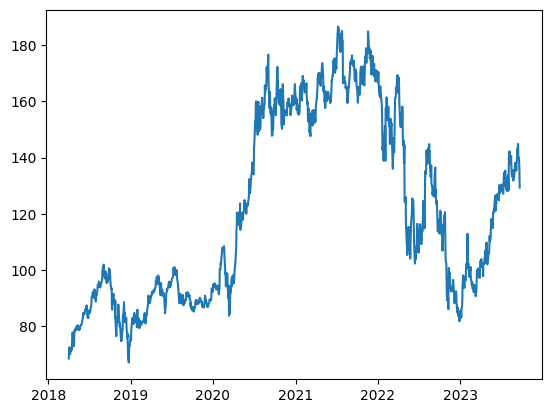

In [25]:
import matplotlib.pyplot as plt

plt.plot(data.index, data['Close'])

In [28]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(data, 
                                '2019-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2019-03-25,89.863503,90.962997,88.238503,88.712997
1,2019-03-26,90.962997,88.238503,88.712997,89.188004
2,2019-03-27,88.238503,88.712997,89.188004,88.285004
3,2019-03-28,88.712997,89.188004,88.285004,88.670998
4,2019-03-29,89.188004,88.285004,88.670998,89.037498
...,...,...,...,...,...
752,2022-03-17,141.852997,147.366501,153.104004,157.238998
753,2022-03-18,147.366501,153.104004,157.238998,161.250504
754,2022-03-21,153.104004,157.238998,161.250504,161.491501
755,2022-03-22,157.238998,161.250504,161.491501,164.889008


In [29]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((757,), (757, 3, 1), (757,))

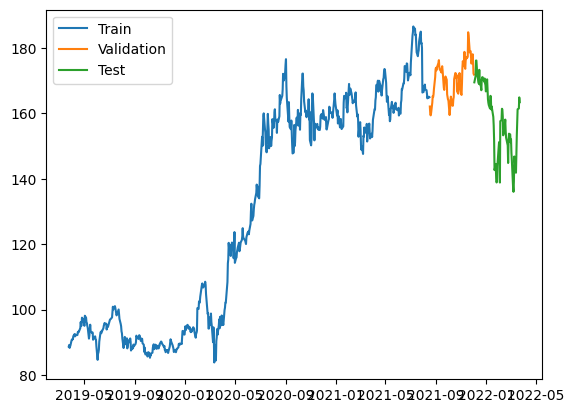

In [30]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
19/19 [==============================] - 2s 22ms/step - loss: 17456.0918 - mean_absolute_error: 127.7288 - val_loss: 28711.0859 - val_mean_absolute_error: 169.3455
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 17173.7793 - mean_absolute_error: 126.6205 - val_loss: 28260.4414 - val_mean_absolute_error: 168.0096
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 16570.9824 - mean_absolute_error: 124.1515 - val_loss: 26895.0898 - val_mean_absolute_error: 163.8949
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 14599.2383 - mean_absolute_error: 115.7569 - val_loss: 22830.9746 - val_mean_absolute_error: 150.9855
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 10316.0703 - mean_absolute_error: 94.8185 - val_loss: 14875.5068 - val_mean_absolute_error: 121.8224
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 4845.0244 - mean_absolute_error: 58.8498 - val_loss:

19/19 [==============================] - 0s 1ms/step


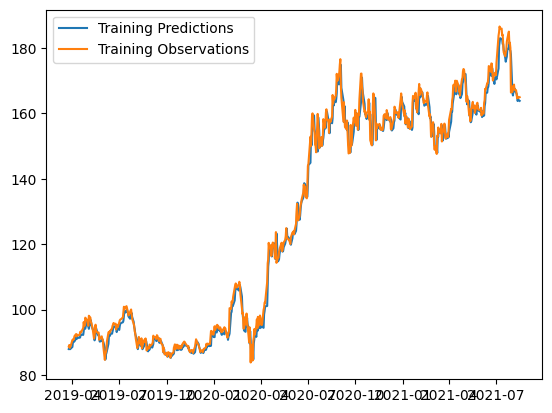

In [32]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 0s/step


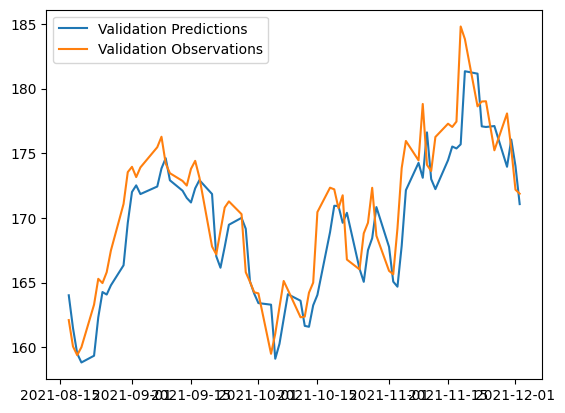

In [33]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 1ms/step


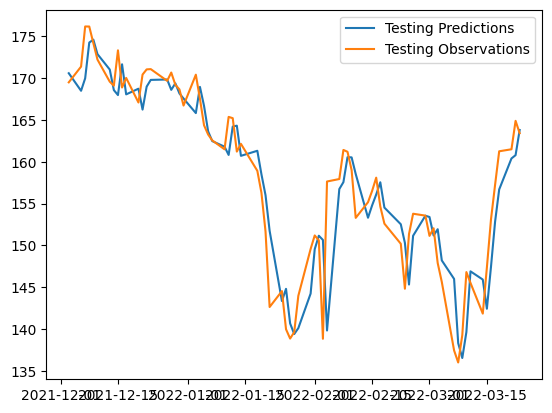

In [34]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

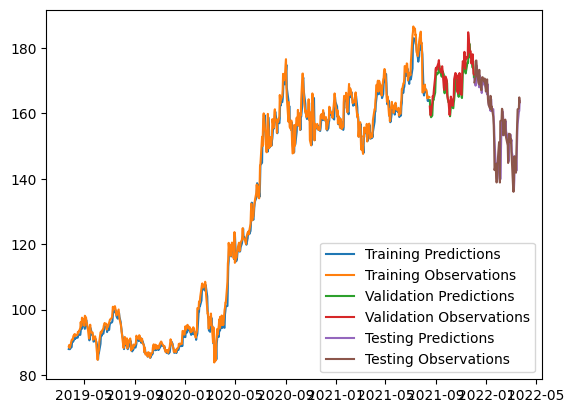

In [35]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [36]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 16ms/step


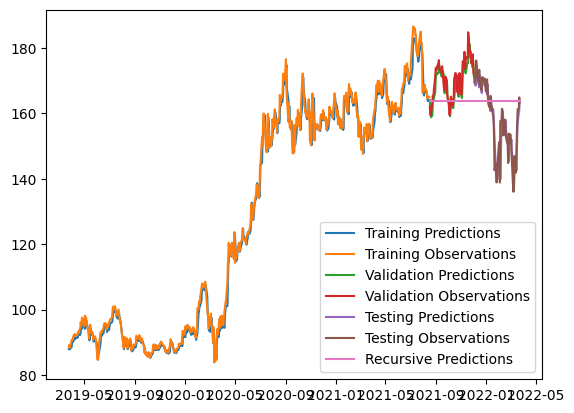

In [37]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])